Let's start by importing some modules :


In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline
plt.style.use('seaborn-whitegrid')
%run BigFont.py

and let's define the global variables of the notebook :


In [2]:
vw = 0.95 # Wall velocity in unity of c
cs = np.sqrt(1./3.) # Sound speed 
T_star = 20. # Temperature in Gev at the GW production
g_star = 100.
gamma = 4./3. # Adiabatic index
window = 1./3. # Set this variable to define the frequency window around the peak for the SNR integration
zp = 10. # value obtained from numerical simulations
OmegaNorm = 0.01 #normally 10**-2
h_small = .678
H_0 = 2.2*10**(-18) # Hubble constant today in Hz
Tau = 3.*365.25*24.*60.*60. #Time of the mission in seconds

We may now start to define the functions needed to estimate the executions variables :

In [3]:
# Function for the estimation of kv, this function will only work in the regime vw~1.

#def kv(alpha):
#    return (alpha/(0.73 + 0.083*np.sqrt(alpha) + alpha))    

# Function for the estimation of kv, as used by David Weir

def kv(alpha):

    kappaA = np.power(vw,6.0/5.0)*6.9*alpha/ \
             (1.36 - 0.037*np.sqrt(alpha) + alpha)
    kappaB = np.power(alpha,2.0/5.0)/ \
             (0.017 + np.power(0.997 + alpha,2.0/5.0))
    kappaC = np.sqrt(alpha)/(0.135 + np.sqrt(0.98 + alpha))
    kappaD = alpha/(0.73 + 0.083*np.sqrt(alpha) + alpha)
    
    xiJ = (np.sqrt((2.0/3.0)*alpha + alpha*alpha) + np.sqrt(1.0/3.0))/(1. + alpha)

    deltaK = -0.9*np.log((np.sqrt(alpha)/(1 + np.sqrt(alpha))))
            
    if vw < cs:
        return np.power(cs,11.0/5.0)*kappaA*kappaB/ \
                ((np.power(cs,11.0/5.0)
                 - np.power(vw,11.0/5.0))*kappaB
                 + vw*np.power(cs,6.0/5.0)*kappaA)
    elif vw > xiJ:
        return np.power(xiJ - 1, 3.0)*np.power(xiJ,5.0/2.0)* \
                np.power(vw,-5.0/2.0)*kappaC*kappaD/ \
                ((np.power(xiJ-1,3.0) - np.power(vw -1,3.0))* \
                 np.power(xiJ,5.0/2.0)*kappaC + np.power(vw - 1,3.0)*kappaD)
    else:
        return kappaB + (vw - cs)*deltaK \
                + (np.power(vw-cs,3.0)/np.power(xiJ-cs,3.0))*(kappaC-kappaB-(xiJ-cs)*deltaK)

In [4]:
# Function for the estimation of the kinetic energy K

def find_K(alpha):
    return ((kv(alpha)*alpha)/(1. + alpha))

In [5]:
# Function used for the estimation of U_bar

def Ubar(alpha):
    return np.sqrt(((1./gamma)*kv(alpha)*alpha)/(1. + alpha))

In [6]:
# Function for the estimation of the value H_star * Tau_sh

def NormTauSh(alpha,norm_beta):
    return ((vw*(8.*np.pi)**(1./3.))/(norm_beta*Ubar(alpha)))

In [7]:
# Function for the estimation of the frequency of the peak of the sound wave

def Find_fsw(alpha, norm_beta):
    return (26.*(10.**(-6))*(norm_beta/(vw*(8.*np.pi)**(1./3.)))*(zp/10.)*(T_star/100.)*((g_star/100.)**(1./6.))) # Hz

In [8]:
# Function for the estimation of the spectral shape of the sound wave 

def SpectralShapeSW(freq, alpha, norm_beta):
    f_sw = Find_fsw(alpha, norm_beta)
    return (((freq/f_sw)**3.)*((7./(4. + 3.*(freq/f_sw)**2.))**(7./2.)))

Hence we may define the sound waves spectral density :

In [9]:
def OmegaSW(freq,alpha,norm_beta):
    
    normtsh = NormTauSh(alpha, norm_beta)
    result  = (h_small**2.)*0.687*3.57*((8.*np.pi)**(1./3.))*(10.**(-5.))*((100./g_star)**(1./3.))*((find_K(alpha))**2.)*(vw/(norm_beta*cs))*OmegaNorm*SpectralShapeSW(freq, alpha, norm_beta)
    if (normtsh <=1) :
        result = result*normtsh
    
    return result
        

In the last two functions, **norm_beta** is equal to $\beta / H_{*}$, all the local variables for this simulation would be setted to the following values : 

Furthermore, we'll need an integration function for the SNR, we will use one function for finding the index within the window and one function that will integrate using the trapeze method :

In [10]:
def IntExtremes(f_sw, window):
    ok = False 
    idx_start = 0
    idx_end = len(df.Frequency) - 1

    for i in range(len(df.Frequency)-2):
        if (df.Frequency[i] - f_sw*(1. - window) > 0.) and (not ok) :
            idx_start = i
            ok = True
        
        if (df.Frequency[i] - f_sw*(1.) > 0.) and ok:            
            idx_end = i
            break
    
    if(idx_end - idx_start <= 0):
        idx_end = idx_start + 1 
            
    return idx_start,idx_end    

In [11]:
def SNR(fid_start,fid_end):
    IntVal1 = 0.
    IntVal2 = 0.
    IntVal3 = 0.
    for i in range(fid_start, fid_end, 1):
        IntVal1 += (df.Frequency[i+1] - df.Frequency[i])*((df.SwSpectrum[i])/(df.First_Sensitivity[i]))**2.
        IntVal2 += (df.Frequency[i+1] - df.Frequency[i])*((df.SwSpectrum[i])/(df.Second_Sensitivity[i]))**2.
        IntVal3 += (df.Frequency[i+1] - df.Frequency[i])*((df.SwSpectrum[i])/(df.Third_Sensitivity[i]))**2.
    SNR1 = np.sqrt(Tau*IntVal1)
    SNR2 = np.sqrt(Tau*IntVal2)
    SNR3 = np.sqrt(Tau*IntVal3)
    return SNR1,SNR2,SNR3

The variables, for the trial run would be set to :

In [12]:
alpha = 0.5 
norm_beta =500 

Let's load the sensitivity curves of the detectors:


In [13]:
df1 = pd.read_csv('S_h_scird.txt', sep=" ", header = None)
df2 = pd.read_csv('S_h_scird_deg1.txt', sep=" ", header = None)
df3 = pd.read_csv('S_h_scird_deg2.txt', sep=" ", header = None)

And let's estimate the amplitude of the sensitivity curves :

In [14]:
df1['Sensitivity'] = ((4.*np.pi**2)/(3*H_0**2))*df1[6]*(df1[3])**3
df2['Sensitivity'] = ((4.*np.pi**2)/(3*H_0**2))*df2[6]*(df2[3])**3
df3['Sensitivity'] = ((4.*np.pi**2)/(3*H_0**2))*df3[6]*(df3[3])**3

Now we may define the complete dataframe as :

In [15]:
d = {'Frequency' : df1[3], 'First_Sensitivity' : df1['Sensitivity'], 'Second_Sensitivity' : df2['Sensitivity'], 'Third_Sensitivity' : df3['Sensitivity']}
df = pd.DataFrame(data = d)

Hence the Spectrum of the sound waves may be added to the dataframe as :

In [16]:
df['SwSpectrum'] = OmegaSW(df['Frequency'], alpha, norm_beta)
f_sw = Find_fsw(alpha, norm_beta)
fid_start,fid_end =IntExtremes(f_sw,window)

Let's try to plot the curves :

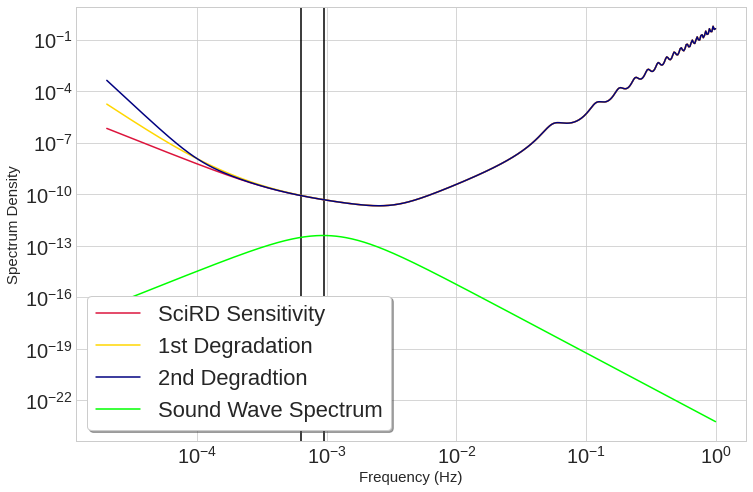

In [17]:
fig = plt.figure(figsize=[12,8])
ax = plt.axes()
ax.axvline(df.Frequency[fid_start],0.,1.,color = 'black') # Uncomment to plot the range of the partial integration 
ax.axvline(df.Frequency[fid_end],0.,1.,color = 'black')   # Uncomment to plot the range of the partial integration
ax.loglog()
ax.plot(df.Frequency, df.First_Sensitivity, color = 'crimson', label = 'SciRD Sensitivity')
ax.plot(df.Frequency, df.Second_Sensitivity, color = 'gold', label = '1st Degradation')
ax.plot(df.Frequency, df.Third_Sensitivity, color = 'navy', label = '2nd Degradtion')
ax.plot(df.Frequency, df.SwSpectrum, color = 'lime', label = 'Sound Wave Spectrum')
ax.set_xlabel('Frequency (Hz)', fontsize = 15)
ax.set_ylabel('Spectrum Density', fontsize = 15)
ax.legend(frameon = True, fancybox = True, shadow = True)

Hence the SNR for the different sensitivities are given by :

In [18]:
# Uncomment the next line for an SNR within the Window
SNR1, SNR2, SNR3 = SNR(0, len(df.Frequency) - 1)
SNRp1, SNRp2, SNRp3 = SNR(fid_start,fid_end)
# Uncomment the next line for an SNR over all the frequency range 
#SNR1, SNR2, SNR3 = SNR(0,len(df.Frequency) - 1)
print("The SNR with the first sensitivity is :", SNR1)
print("The SNR with the second sensitivity is :", SNR2)
print("The SNR with the third sensitivity is :", SNR3)
print("The partial SNR with the first sensitivity is :", SNRp1)
print("The partial SNR with the second sensitivity is :", SNRp2)
print("The partial SNR with the third sensitivity is :", SNRp3)

The SNR with the first sensitivity is : 3.338078463021115
The SNR with the second sensitivity is : 3.3204225283734354
The SNR with the third sensitivity is : 3.337888557215548
The partial SNR with the first sensitivity is : 1.0788877823312955
The partial SNR with the second sensitivity is : 1.064338960362808
The partial SNR with the third sensitivity is : 1.0786480053301704


We now have to show as the SNR behaves in function of the spanned variables, let's define some result matrix :

In [19]:
Z1 = np.zeros((200,200))
Z2 = np.zeros((200,200))
Z3 = np.zeros((200,200))
Zp1 = np.zeros((200,200))
Zp2 = np.zeros((200,200))
Zp3 = np.zeros((200,200))

Let's also define the span of the two variables as :

In [20]:
log_span_alpha = np.linspace(-1,1,200)
span_alpha = 1*10**(log_span_alpha)
log_span_beta = np.linspace(0,4,200)
span_beta = 1.*10**(log_span_beta)
X, Y = np.meshgrid(span_alpha, span_beta)

some benchmark points can be loaded from the file :

In [21]:
df_nm = 'BPT20.h5'
BenPoints = pd.read_hdf(df_nm)

We just have to run over the simulation over the values :

In [22]:
for i in tqdm(range(200)):
    for j in range(200):
        df['SwSpectrum'] = OmegaSW(df['Frequency'], X[j][i], Y[j][i])
        
        #Uncomment this section for an SNR analysis within the window
        
        f_sw = Find_fsw(X[j][i], Y[j][i])
        fid_start,fid_end =IntExtremes(f_sw,window)
        Z1[j][i],Z2[j][i],Z3[j][i] = SNR(0, len(df.Frequency) - 1)
        Zp1[j][i],Zp2[j][i],Zp3[j][i] = SNR(fid_start,fid_end)
        
        #Uncomment this section for an SNR analysis in the whole Frequency range
        
        #Z1[j][i],Z2[j][i],Z3[j][i] = SNR(0, len(df.Frequency) - 1)

100%|█████████████████████████████████████████| 200/200 [25:47<00:00,  7.74s/it]


We just have to plot the results for the 3 different sensitivity curves :

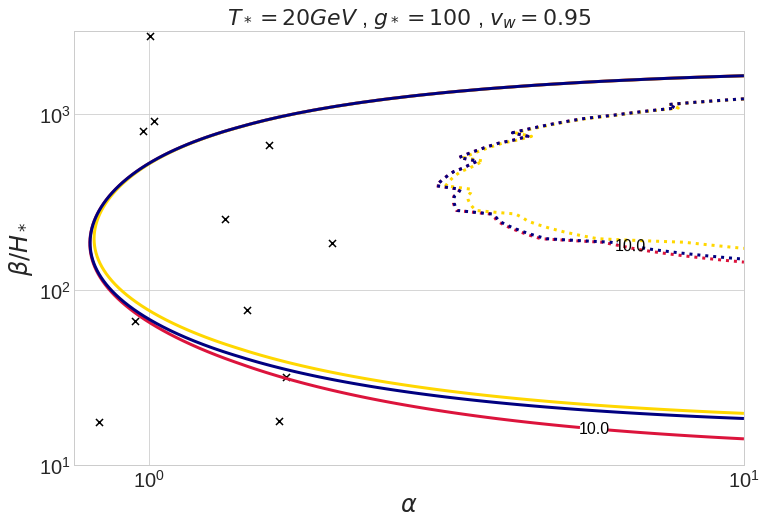

In [31]:
# Uncomment this block for a single plot of the 3 contour line

fig, ax = plt.subplots(figsize = [12,8])
#Choose level range levels=[0.1, 1, 10]
c1 = ax.contour(X, Y, Z1, levels=[10.], colors = 'crimson', linestyles = '-', linewidths = 3)
c2 = ax.contour(X, Y, Z2, levels=[10.], colors = 'gold', linestyles = '-', linewidths = 3)
c3 = ax.contour(X, Y, Z3, levels=[10.], colors='navy', linestyles = '-', linewidths = 3)
cp1 = ax.contour(X, Y, Zp1, levels=[10.], colors = 'crimson', linestyles = ':', linewidths = 3)
cp2 = ax.contour(X, Y, Zp2, levels=[10.], colors = 'gold', linestyles = ':', linewidths = 3)
cp3 = ax.contour(X, Y, Zp3, levels=[10.], colors='navy', linestyles = ':', linewidths = 3)
sp = ax.scatter(BenPoints['alpha'], BenPoints['beta'], s=50, marker = 'x', c = 'black')
ax.clabel(c1, inline=True, fmt = '%1.1f', fontsize=16, colors = 'black')
ax.clabel(cp3, inline=True, fmt = '%1.1f', fontsize=16, colors = 'black')
lines = [c1.collections[0], c2.collections[0], c3.collections[0], cp1.collections[0], cp2.collections[0], cp3.collections[0]]
labels = ['SciRD Sensitivity','1st Degradation','2nd Degradation', 'SciRD Sensitivity partial $(2./3. * f_sw$ , $f_sw)$','1st Degradation partial $(2./3. * f_sw$ , $f_sw)$','2nd Degradation partial $(2./3. * f_sw$ , $f_sw)$']
ax.set_xlabel(r'$\alpha$', fontsize = 24)
ax.set_ylabel(r'$\beta / H_*$', fontsize = 24)
ax.loglog()
ax.set_ylim(1.e1,3e3)
ax.set_xlim(0.75e0,1e1)
ax.set_title('$T_* = 20 GeV$ , $g_* = 100$ , $v_w = 0.95$', fontsize = 22)
#ax.legend(lines, labels, loc=2, frameon = True, fancybox = True, shadow = True)
fig.savefig('FOM20Gev.png', dpi = 500)

In [24]:
# Uncomment the next 3 block for the single plots

#fig, ax = plt.subplots(figsize = [12,8])
#c1 = ax.contour(X, Y, Z1, levels=[1, 10,50,100], cmap = 'jet');
#ax.clabel(c1, inline=True, fmt = '%1.0f', fontsize=10, colors = 'black')
#lines = [ c1.collections[0]]
#labels = ['SciRD Sensitivity']
#ax.set_xlabel(r'$\alpha$', fontsize = 15)
#ax.set_ylabel(r'$\beta / H_*$', fontsize = 15)

#ax.loglog()
#plt.legend(lines, labels)

In [25]:
#fig, ax = plt.subplots(figsize = [12,8])
#c2 = ax.contour(X, Y, Z2, levels=[1, 10,50,100], cmap = 'jet');
#ax.clabel(c2, inline=True, fmt = '%1.0f', fontsize=10, colors = 'black')
#lines = [c2.collections[0]]
#labels = ['1st Degradation']
#ax.set_xlabel(r'$\alpha$', fontsize = 15)
#ax.set_ylabel(r'$\beta / H_*$', fontsize = 15)

#ax.loglog()
#plt.legend(lines, labels)

In [26]:
#fig, ax = plt.subplots(figsize = [12,8])
#c3 = ax.contour(X, Y, Z3, levels=[1, 10,50,100], cmap = 'jet');
#ax.clabel(c3, inline=True, fmt = '%1.0f', fontsize=10, colors = 'black')
#lines = [c3.collections[0]]
#labels = ['2nd Degradation']
#ax.set_xlabel(r'$\alpha$', fontsize = 15)
#ax.set_ylabel(r'$\beta / H_*$', fontsize = 15)

#ax.loglog()
#plt.legend(lines, labels)

<h2> Setting alarm for the end of the simulation </h2>

In [27]:
file = 'Alarm-ringtone.mp3'
os.system("mpg123 "+file)


High Performance MPEG 1.0/2.0/2.5 Audio Player for Layers 1, 2 and 3
	version 1.25.13; written and copyright by Michael Hipp and others
	free software (LGPL) without any warranty but with best wishes

Playing MPEG stream 1 of 1: Alarm-ringtone.mp3 ...

MPEG 1.0 L III cbr192 44100 j-s

Title:                                   Artist:                               
Comment:                                 Album:                                
Year:                                    Genre:  Other                         

[0:17] Decoding of Alarm-ringtone.mp3 finished.


0